In [1]:
pip install tensorflow  opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'D:\ImageClassification\imageclasskernel\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import os

# 2. Remove dodgy images

In [3]:
import cv2
import imghdr

In [4]:
data_dir = 'data' 

In [5]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri setinin bulunduğu dizin
data_dir = 'data'  # Bu kısmı kendi veri seti klasörünüz ile değiştirin

# Sınıf etiketleri
class_labels = ['cloudy', 'dew', 'fogsmog', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'shine', 'snow', 'sunrise']
num_classes = len(class_labels)

# ImageDataGenerator kullanarak veri yüklemek
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Veri setini yükleme ve eğitim/test olarak ayırma
train_data = datagen.flow_from_directory(
    data_dir, 
    target_size=(256, 256), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training', 
    classes=class_labels
)

test_data = datagen.flow_from_directory(
    data_dir, 
    target_size=(256, 256), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation', 
    classes=class_labels
)


Found 7704 images belonging to 12 classes.
Found 1917 images belonging to 12 classes.


In [22]:
from sklearn.model_selection import KFold

# Veri setini yükleme ve eğitim/test olarak ayırma
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Veri setini yükleme
train_data = datagen.flow_from_directory(data_dir, target_size=(256, 256), batch_size=32, class_mode='categorical', subset='training', classes=class_labels)

# Çapraz doğrulama için katman sayısını belirtin
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Çapraz doğrulama puanlarını depolamak için bir liste oluşturun
cv_results = []

for train_index, test_index in kfold.split(train_data):
    train_subset = tf.data.Dataset.from_generator(lambda: train_data, output_signature=(tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32), tf.TensorSpec(shape=(None, len(class_labels)), dtype=tf.float32)))
    test_subset = tf.data.Dataset.from_generator(lambda: train_data, output_signature=(tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32), tf.TensorSpec(shape=(None, len(class_labels)), dtype=tf.float32)))

    X_train, y_train = next(iter(train_subset))
    X_test, y_test = next(iter(test_subset))

    # Modeli oluşturun
    model = Sequential()

    model.add(BatchNormalization(input_shape=(256, 256, 3)))

    # Convolutional Block 1
    model.add(Conv2D(32, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))

    # Convolutional Block 2
    model.add(Conv2D(64, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.50))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Modeli derleme
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Modeli eğitme
    hist = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
    
    # Modeli değerlendirme
    accuracy = model.evaluate(X_test, y_test)
    cv_results.append(accuracy)

print("Çapraz Doğrulama Puanları: ", cv_results)

# Her bir çapraz doğrulama sonucunu topla
total_accuracy = sum([result[1] for result in cv_results])

# Toplamı çapraz doğrulama seti sayısına bölerek ortalama doğruluk elde et
average_accuracy = total_accuracy / len(cv_results)

print("Ortalama Doğruluk: ", average_accuracy)


Found 7704 images belonging to 12 classes.
Epoch 1/100
1/1 [==============================] - 9s 9s/step - loss: 2.6253 - accuracy: 0.1250 - val_loss: 7.6845 - val_accuracy: 0.0312
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 19.9235 - accuracy: 0.1250 - val_loss: 3.0413 - val_accuracy: 0.2188
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 14.7792 - accuracy: 0.1562 - val_loss: 2.7168 - val_accuracy: 0.0625
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 13.1844 - accuracy: 0.1250 - val_loss: 2.3468 - val_accuracy: 0.1875
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 4.8104 - accuracy: 0.3125 - val_loss: 2.4312 - val_accuracy: 0.0938
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 4.2189 - accuracy: 0.1562 - val_loss: 2.5196 - val_accuracy: 0.1250
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 2.6761 - accuracy: 0.2188 - val_loss: 2.4955 - val_accur

In [23]:
total_accuracy = sum([result[1] for result in cv_results])

# Toplamı çapraz doğrulama seti sayısına bölerek ortalama doğruluk elde et
average_accuracy = total_accuracy / len(cv_results)

print("Ortalama Doğruluk: ", average_accuracy)

# Test veri kümesi üzerinde modeli değerlendirme
test_accuracy = model.evaluate(test_data)
print("Test Doğruluğu:", test_accuracy[1])


Ortalama Doğruluk:  0.29375
60/60 [==============================] - 24s 379ms/step - loss: 3.2634 - accuracy: 0.2567
Test Doğruluğu: 0.25665101408958435


In [24]:
data_iterator = data.as_numpy_iterator()

NameError: name 'data' is not defined

In [ ]:
batch = data_iterator.next()

# 4. Scale Data

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
# Veri setini normalize etme ve one-hot encoding uygulama
data = data.map(lambda x, y: (x / 255, tf.one_hot(y, depth=14)))


In [ ]:
data.as_numpy_iterator().next() 

# 5. Split Data

In [ ]:
from collections import Counter
class_labels = ['cloudy', 'dew', 'fogsmog', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'shine', 'snow', 'sunrise']

# Train setindeki sınıfların örnek sayıları
train_class_counts = Counter([class_labels[np.argmax(label.numpy())] for _, label in train])

# Test setindeki sınıfların örnek sayıları
test_class_counts = Counter([class_labels[np.argmax(label.numpy())] for _, label in test])

print("Train seti sınıf örnek sayıları:")
print(train_class_counts)

print("\nTest seti sınıf örnek sayıları:")
print(test_class_counts)


# 6. Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Veri artırma işlemleri için ImageDataGenerator oluştur
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=0.5,
    vertical_flip=0.005,
    channel_shift_range=0.10,
    brightness_range=(0.3, 0.3),
    #rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Örnek bir görüntü yükleyin (bu, sizin gerçek görüntü yüklemeye uyarlamanız gereken bir yerdir)
image_path = 'data/snow/0853.jpg'
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Görüntüyü ekrana basmadan önce normalize et
original_image_normalized = original_image / 255.0

# Görüntüyü yeniden boyutlandır (ImageDataGenerator beklediği giriş boyutuna uygun olarak)
original_image_resized = tf.image.resize(original_image_normalized, (256, 256))

# Artırılmış görüntüyü oluştur
augmented_images = datagen.flow(tf.expand_dims(original_image_resized, axis=0), batch_size=1)
augmented_image = augmented_images.next()[0]

# Orijinal ve artırılmış görüntüyü göster
plt.subplot(1, 2, 1)
plt.imshow(original_image_resized.numpy())
plt.title('Orijinal Görüntü')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title('Artırılmış Görüntü')

plt.show()


# 7. CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization

In [ ]:
num_classes = 12 # Toplam sınıf sayısı

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

model.add(BatchNormalization(input_shape=(256, 256, 3)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

# 8. Train

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
hist = model.fit(train, epochs=30, validation_data=val,  callbacks=[tensorboard_callback, early_stopping])

# 9. Plot Performance

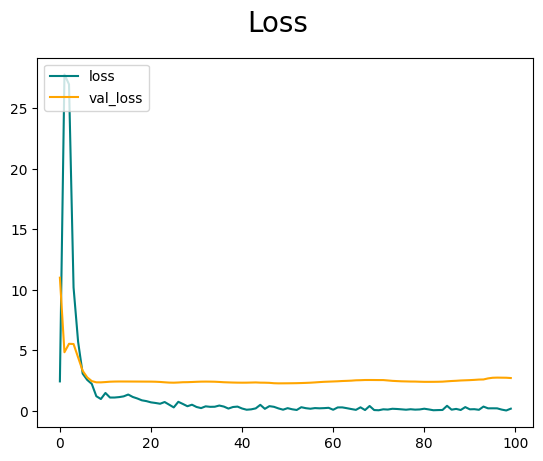

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

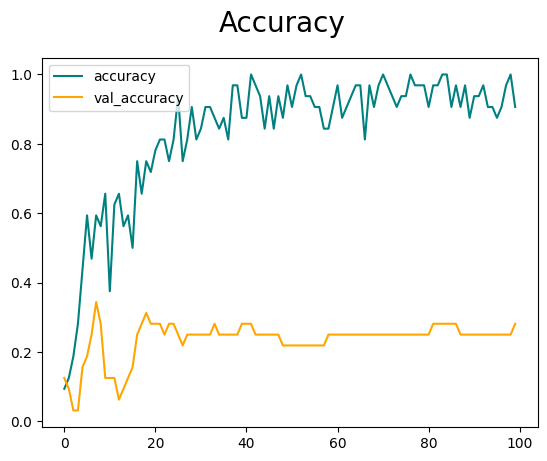

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 10. Evaluate

In [28]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy

In [29]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

NameError: name 'data' is not defined

In [30]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
test = data.skip(train_size + val_size).take(test_size)

In [27]:
accuracy_metric = Accuracy()

for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    acc.update_state(y, yhat)
    accuracy_metric.update_state(tf.argmax(y, axis=1), tf.argmax(yhat, axis=1))


test_accuracy = accuracy_metric.result().numpy()
print(f'Test Accuracy: {test_accuracy}')

NameError: name 'Accuracy' is not defined

# 11. Test

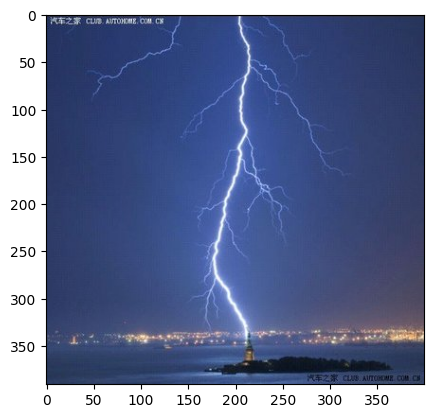

In [31]:
# Görüntüyü okuma ve uygun formatta yükleme
img = cv2.imread('data/lightning/1830.jpg')

# Görüntü boş mu kontrolü
if img is not None:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV, görüntüyü BGR formatında okur, bu nedenle RGB'ye dönüştürüyoruz

    # Görüntüyü gösterme
    plt.imshow(img)
    plt.show()
else:
    print("Görüntü yüklenemedi.")

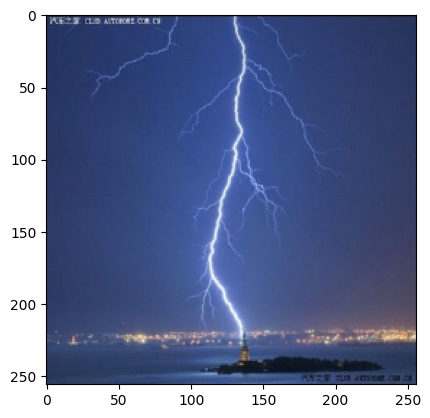

In [32]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [33]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 146ms/step


In [34]:
yhat

array([[0.00265359, 0.00314131, 0.00821853, 0.09235846, 0.00711275,
        0.26677957, 0.01672739, 0.01225274, 0.00345708, 0.5819036 ,
        0.00374108, 0.00165387]], dtype=float32)

In [35]:
img_path = 'data/cloudy/cloudy10.jpg'
img = cv2.imread(img_path)

if img is not None:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize = tf.image.resize(img, (256, 256))
    resize = np.expand_dims(resize / 255, 0)  

else:
    print(f"Error: Unable to read the image at {img_path}")


In [36]:
class_names = ['cloudy', 'dew', 'fogsmog', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'shine', 'snow', 'sunrise']
predictions = model.predict(resize)
predicted_class = np.argmax(predictions, axis=-1)

# Print some debug information
print(f'Predicted class indices: {predicted_class}')
if 0 <= predicted_class[0] < len(class_names):
    predicted_class_label = class_names[predicted_class[0]]
    print(f'Predicted class: {predicted_class_label}')
else:
    print('Error: Predicted class index is out of range.')

# Print class probabilities
for i, prob in enumerate(predictions[0]):
    class_label = class_names[i]
    print(f'Probability for class {class_label}: {prob}')


1/1 [==============================] - 0s 50ms/step
Predicted class indices: [9]
Predicted class: shine
Probability for class cloudy: 0.00041639889241196215
Probability for class dew: 0.00013474479783326387
Probability for class fogsmog: 0.01411471888422966
Probability for class glaze: 0.002960345707833767
Probability for class hail: 0.0006731912144459784
Probability for class lightning: 0.004227247554808855
Probability for class rain: 0.0003579395997803658
Probability for class rainbow: 0.001218936056829989
Probability for class rime: 0.0012791358167305589
Probability for class shine: 0.9742955565452576
Probability for class snow: 0.0003122908528894186
Probability for class sunrise: 9.447136108065024e-06


# 12. Save Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','weatherforecast18.h5'))

In [ ]:
new_model = load_model('D:\ImageClassification\models\weatherforecast18.h5')

In [ ]:
model.load_weights('D:\ImageClassification\models\weatherforecast18.h5')

# 13. Confussion Matrix

In [ ]:
pip install -U scikit-learn scipy matplotlib

In [ ]:
!pip install seaborn

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


# Confusion Matrix'i oluşturun
conf_mat = confusion_matrix(all_y_true, all_y_pred)

# Sınıf isimleri
class_names = ['cloudy', 'dew', 'fogsmog','glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'shine', 'snow', 'sunrise']

# Pandas DataFrame'e dönüştürme
conf_mat_df = pd.DataFrame(conf_mat, index=class_names, columns=class_names)

# Confusion Matrix'i çizme
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat_df, annot=True, fmt='g', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Çapraz Doğrulama Puanları: ", cv_results)
print("Ortalama Doğruluk: ", average_accuracy)
